Funziona: https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial119_multiclass_semantic_segmentation.ipynb

In [1]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
#from patchify import patchify
from PIL import Image
#import segmentation_models as sm
import tensorflow as tf
#from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import load_model
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
#from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
#from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `keras` framework.


In [2]:
# loading image data...
def image_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path)
        image = cv2.resize(image, (sx,sy))
        image_dataset.append(image)
    return image_dataset

In [3]:
# loading image data...
def mask_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        #print(path)
        image = cv2.imread(path, 0)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (sx,sy))
        #image = Image.fromarray(image)
        #image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [4]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "car-segmentation", "images")
masks_folder = os.path.join("..", "car-segmentation", "masks")
n_classes = 5 # class for segmentation
size_x = 128
size_y = 128

image_dataset = image_loader(img_folder,size_x,size_y) # real images...
mask_dataset = mask_loader(masks_folder,size_x,size_y) # masked images...
image_dataset = np.array(image_dataset)
#image_dataset = np.expand_dims(image_dataset, axis = 3) # per creare la giusta struttura
mask_dataset = np.array(mask_dataset)
#Espando la dimensione anche della maschera
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)



In [5]:
print(image_dataset.shape)
print(mask_dataset_encoded.shape)
print("Image shape: ", image_dataset[0].shape)
print("Mask shape: ", mask_dataset_encoded[0].shape)
print("Max pixel value in image is: ", image_dataset.max()) #255 perchè non è normalizzata
print("Labels in the mask are : ", np.unique(mask_dataset_encoded))

(1688, 128, 128, 3)
(1688, 128, 128, 1)
Image shape:  (128, 128, 3)
Mask shape:  (128, 128, 1)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4]


In [6]:

#Normalize images (pixel diventano tra 0 e 1)
image_dataset = image_dataset /255. 

In [7]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
     

In [8]:
#Le maschere devono avere il formato dell'ultimo layer del modello (128x128x5)
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print("shape precedente: ", y_train.shape)
print("shape attuale: ", y_train_cat.shape)


shape precedente:  (1350, 128, 128, 1)
shape attuale:  (1350, 128, 128, 5)


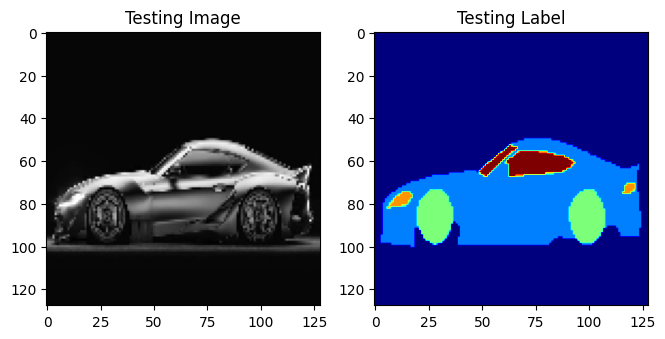

In [12]:
#Sanity check delle immagini
n = random.randint(0, len(X_test)-1)
test_img = X_train[n]
ground_truth=y_train[n]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

In [13]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p  
#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model 


In [14]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(128, 128, 3)


In [15]:
model = build_unet(input_shape, n_classes=n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(1350, 128, 128, 3)
(338, 128, 128, 3)
(1350, 128, 128, 5)
(338, 128, 128, 5)


In [17]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('UNet6_RGB_results.log', separator=',', append=False)
callbacks =[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=15, #25
                    validation_data=(X_test, y_test_cat), 
                    callbacks=[callbacks,csv_logger],
                    shuffle=False)

Epoch 1/15
85/85 [==============================] - 1106s 13s/step - loss: 0.5236 - accuracy: 0.8243 - val_loss: 5.5559 - val_accuracy: 0.3761
Epoch 2/15
85/85 [==============================] - 937s 11s/step - loss: 0.2575 - accuracy: 0.9098 - val_loss: 2.0257 - val_accuracy: 0.5579
Epoch 3/15
85/85 [==============================] - 935s 11s/step - loss: 0.1998 - accuracy: 0.9288 - val_loss: 1.2774 - val_accuracy: 0.7226
Epoch 4/15
 2/85 [..............................] - ETA: 14:40 - loss: 0.2329 - accuracy: 0.9196

In [48]:
model.save(os.path.join("..",'UNet6_RGB_result.hdf5'))

In [ ]:
### Fit and Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

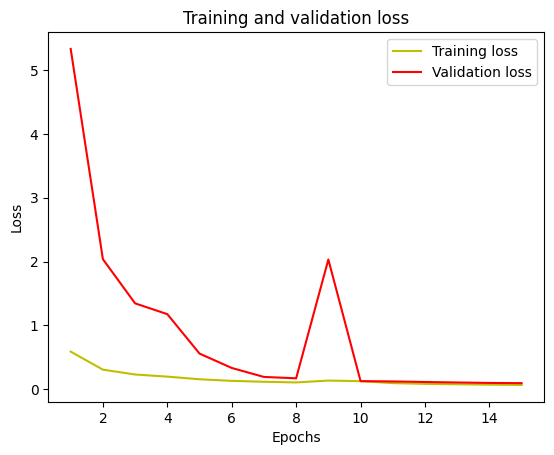

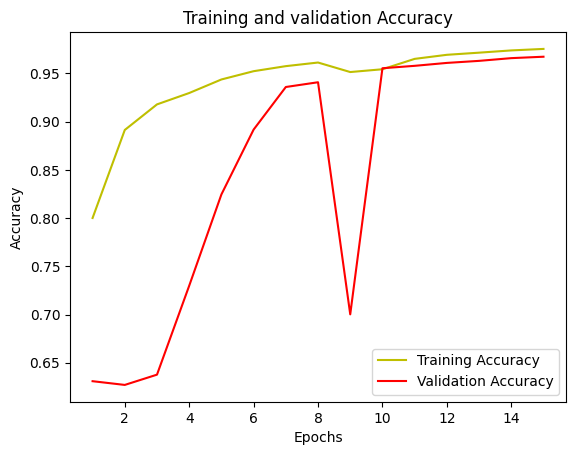

In [49]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:

#Load previously saved model
from keras.models import load_model
path = os.path.join("..", "UNet6_RGB_result.hdf5")
model = load_model(path) #tf.keras.models.load_model
model.summary()
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
y_pred=model.predict(X_test)
y_pred.shape #5 canali (correttamente)

11/11 [==============================] - 62s 6s/step


(338, 128, 128, 5)

In [59]:
#Argmax controlla il valore maggiore dell'asse indicato e prende solo quello
y_pred_argmax=np.argmax(y_pred, axis=3) 
y_pred_argmax.shape

(338, 128, 128)

1/1 [==============================] - 0s 190ms/step


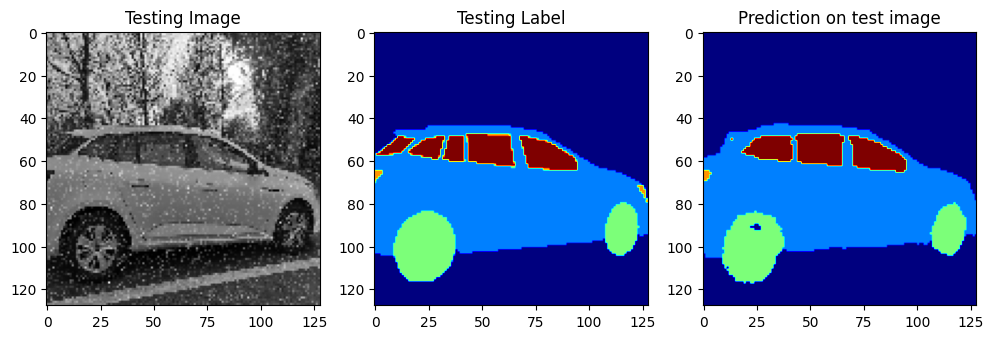

In [62]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()